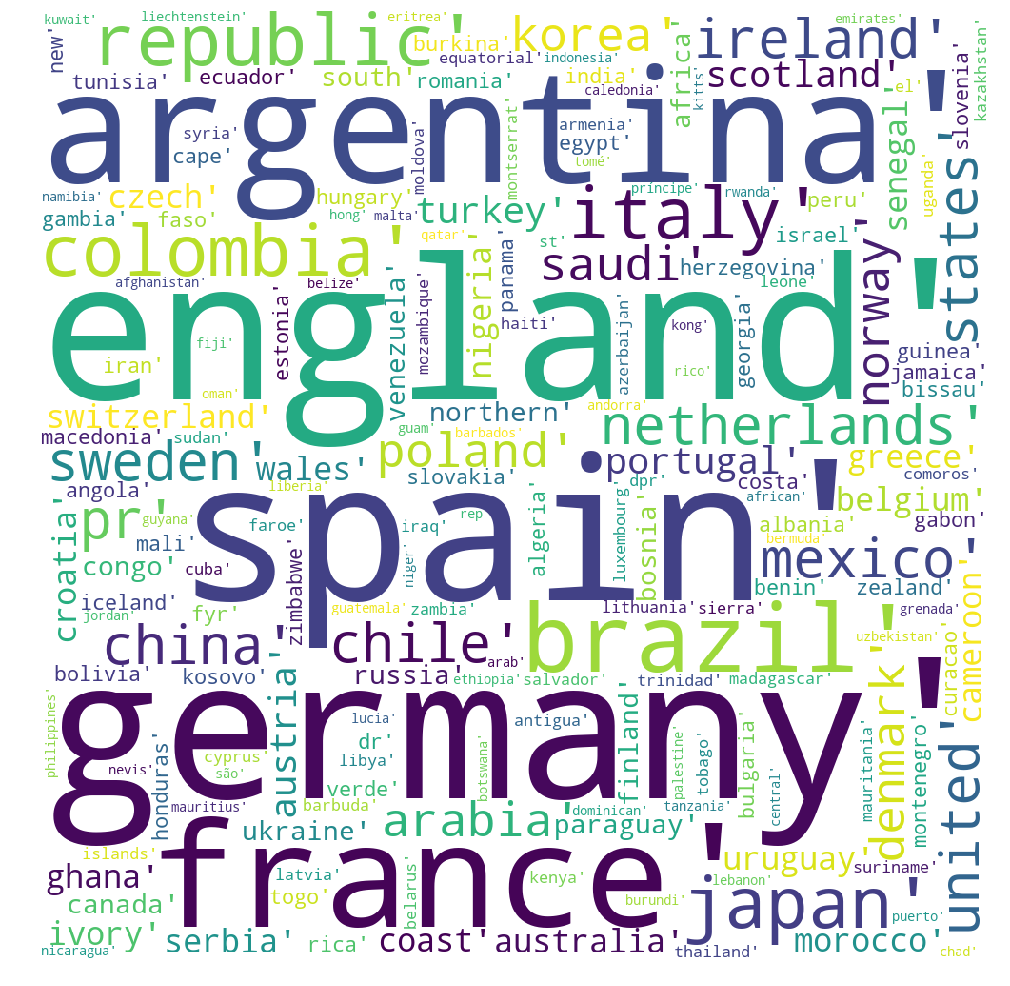

In [27]:
#Idea di copertina presa dall'internet (e adattata al mio caso)
plt.figure(figsize=(17.5,17.5))
makeWordCloud(fifa19,'Nationality',10000000)

In [17]:
import pandas as pd
import numpy as np
import scipy as sc
import seaborn as sns
from nltk import FreqDist
import operator
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB
import pylab as plt
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
from nltk.corpus import stopwords

%matplotlib inline 

path = "./fifa19.csv"

In [2]:
def confronto_algoritmi(alg1, alg2, alg3, alg4, dataset, number_of_iterations=10):
    results1 = []
    results2 = []
    results3 = []
    results4 = []
    
    X_train, X_test, y_train, y_test = train_test_split(dataset.iloc[:,:-1], dataset.iloc[:,-1], random_state=0)
    
    for i in range(1,number_of_iterations+1):
        algoritmo1 = alg1().fit(X_train, y_train)
        algoritmo2 = alg2().fit(X_train, y_train)
        algoritmo3 = alg3().fit(X_train, y_train)
        algoritmo4 = alg4().fit(X_train, y_train)
    
        y_results1 = algoritmo1.predict(X_test)
        y_results2 = algoritmo2.predict(X_test)
        y_results3 = algoritmo3.predict(X_test)
        y_results4 = algoritmo4.predict(X_test)
    
        results1.append(metrics.accuracy_score(y_test, y_results1))
        results2.append(metrics.accuracy_score(y_test, y_results2))
        results3.append(metrics.accuracy_score(y_test, y_results3))
        results4.append(metrics.accuracy_score(y_test, y_results4))
    
    return [(alg1.__name__ ,np.mean(results1)), (alg2.__name__, np.mean(results2)), \
            (alg3.__name__, np.mean(results3)), (alg4.__name__, np.mean(results4))]

In [18]:
def makeWordCloud(df,column,numWords):
    topic_words = [ z.lower() for y in
                       [ x.split() for x in df[column] if isinstance(x, str)]
                       for z in y]
    word_count_dict = dict(Counter(topic_words))
    popular_words = sorted(word_count_dict, key = word_count_dict.get, reverse = True)
    popular_words_nonstop = [w for w in popular_words if w not in stopwords.words("english")]
    word_string=str(popular_words_nonstop)
    wordcloud = WordCloud(stopwords=STOPWORDS,
                          background_color='white',
                          max_words=numWords,
                          width=1000,height=1000,
                         ).generate(word_string)
    plt.clf()
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

________________________________________________________________________________________________________________________________

# FIFA 19 players position
### Demian Zendron

Lo scopo che mi sono posto è di riuscire a predire la posizione in campo di un giocatore di calcio, partendo da un dettagliato dataset di Fifa 19 contente tutte le informazioni che mi servono. 

Vediamo le fasi che affronteremo per arrivare a questo obiettivo:
- Esplorazione e selezione dei dati
- Normalizzazione dei dati
- Predire target binari (attacco VS difesa) con Logistic Regression e Decision Tree
    - Confronto con altri classificatori
- Predire tutte le posizioni con Logistic Regression  e Decision Tree
    - Confrontro con altri classificatori
    - Normalizzazione del dataframe
    - Giocare con i parametri di Logistic Regression
- Riassunto delle fasi, raccolta esiti e conclusioni

**SOURCE:** https://www.kaggle.com/karangadiya/fifa19

## FASE 1: Esplorazione e selezione dei dati

In [21]:
fifa19 = pd.read_csv(path, sep=",", error_bad_lines=False, index_col=False, dtype='unicode')
fifa19.head(10)

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,...,96,33,28,26,6,11,15,14,8,€226.5M
1,1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,...,95,28,31,23,7,11,15,14,11,€127.1M
2,2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,...,94,27,24,33,9,9,15,15,11,€228.1M
3,3,193080,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,...,68,15,21,13,90,85,87,88,94,€138.6M
4,4,192985,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,...,88,68,58,51,15,13,5,10,13,€196.4M
5,5,183277,E. Hazard,27,https://cdn.sofifa.org/players/4/19/183277.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,91,Chelsea,...,91,34,27,22,11,12,6,8,8,€172.1M
6,6,177003,L. Modrić,32,https://cdn.sofifa.org/players/4/19/177003.png,Croatia,https://cdn.sofifa.org/flags/10.png,91,91,Real Madrid,...,84,60,76,73,13,9,7,14,9,€137.4M
7,7,176580,L. Suárez,31,https://cdn.sofifa.org/players/4/19/176580.png,Uruguay,https://cdn.sofifa.org/flags/60.png,91,91,FC Barcelona,...,85,62,45,38,27,25,31,33,37,€164M
8,8,155862,Sergio Ramos,32,https://cdn.sofifa.org/players/4/19/155862.png,Spain,https://cdn.sofifa.org/flags/45.png,91,91,Real Madrid,...,82,87,92,91,11,8,9,7,11,€104.6M
9,9,200389,J. Oblak,25,https://cdn.sofifa.org/players/4/19/200389.png,Slovenia,https://cdn.sofifa.org/flags/44.png,90,93,Atlético Madrid,...,70,27,12,18,86,92,78,88,89,€144.5M


Come possiamo notare le colonne del dataset non sono tutte rilevanti e sono davvero molte, indaghiamole e ragioniamo su quali possano essere utili e quali meno

Prima di procedere alla rimozione creiamo una copia del dataframe, per non operare direttamente su quello originale

In [5]:
fifa19_clean = fifa19.copy()

fifa19_clean.columns

Index(['Unnamed: 0', 'ID', 'Name', 'Age', 'Photo', 'Nationality', 'Flag',
       'Overall', 'Potential', 'Club', 'Club Logo', 'Value', 'Wage', 'Special',
       'Preferred Foot', 'International Reputation', 'Weak Foot',
       'Skill Moves', 'Work Rate', 'Body Type', 'Real Face', 'Position',
       'Jersey Number', 'Joined', 'Loaned From', 'Contract Valid Until',
       'Height', 'Weight', 'LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW',
       'LAM', 'CAM', 'RAM', 'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM',
       'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB', 'Crossing',
       'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
       'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
       'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'Marking', 'StandingTackle', 'SlidingT

In questo caso, anzichè fare un drop per eliminare le colonne non necessarie, facciamo prima ad identificare quelle a noi utili

Selezioniamole e poi cerchiamo di dargli un ordine sensato

In [6]:
columns_needed = ['Position', 'Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
        'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration', 'SprintSpeed', 'Agility', 'Reactions', 
        'Balance', 'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression', 'Interceptions', 
        'Positioning', 'Vision', 'Penalties', 'Composure', 'Marking', 'StandingTackle', 'SlidingTackle']

# attack attribute first, then defence, then mixed
columns_needed_rearranged = ['Aggression', 'Crossing', 'Curve', 'Dribbling', 'Finishing', 'FKAccuracy', 'HeadingAccuracy', 
    'LongShots', 'Penalties', 'ShotPower', 'Volleys', 'ShortPassing', 'LongPassing', 'Interceptions', 'Marking',  
    'SlidingTackle', 'StandingTackle', 'Strength', 'Vision', 'Acceleration', 'Agility', 'Reactions', 'Stamina',
    'BallControl', 'Balance', 'Composure', 'Jumping', 'SprintSpeed', 'Positioning', 'Position']

**NB:** Usando questi parametri sarebbe troppo facile:

    'LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW', 'LAM', 'CAM', 'RAM', 'LM', 'LCM', 
    'CM', 'RCM', 'RM', 'LWB','LDM', 'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB'

. . quindi li toglieremo assieme ai dati che non indicano valori rilevanti sulla prestanza fisica dei giocatori

In [7]:
fifa19_clean = fifa19_clean[columns_needed_rearranged]
fifa19_clean.head(10)

,Aggression,Crossing,Curve,Dribbling,Finishing,FKAccuracy,HeadingAccuracy,LongShots,Penalties,ShotPower,...,Agility,Reactions,Stamina,BallControl,Balance,Composure,Jumping,SprintSpeed,Positioning,Position
0,48,84,93,97,95,94,70,94,75,85,...,91,95,72,96,95,96,68,86,94,RF
1,63,84,81,88,94,76,89,93,85,95,...,87,96,88,94,70,95,95,91,95,ST
2,56,79,88,96,87,87,62,82,81,80,...,96,94,81,95,84,94,61,90,89,LW
3,38,17,21,18,13,19,21,12,40,31,...,60,90,43,42,43,68,67,58,12,GK
4,76,93,85,86,82,83,55,91,79,91,...,79,91,90,91,77,88,63,76,87,RCM
5,54,81,83,95,84,79,61,80,86,82,...,95,90,83,94,94,91,56,88,87,LF
6,62,86,85,90,72,78,55,82,82,79,...,93,90,89,93,94,84,68,72,79,RCM
7,87,77,86,87,93,84,77,85,85,86,...,82,92,90,90,83,85,69,75,92,RS
8,88,66,74,63,60,72,91,59,75,79,...,78,85,84,84,66,82,93,75,60,RCB
9,34,13,13,12,11,14,15,12,11,22,...,67,86,41,16,49,70,76,60,11,GK


In [8]:
print("Considerando le colonne contenute in 'columns_needed_rearranged', \
il dataset che sfrutteremo per train e test ha la seguente \nforma:", fifa19_clean.shape,)

Considerando le colonne contenute in 'columns_needed_rearranged', il dataset che sfrutteremo per train e test ha la seguente 
forma: (18207, 30)


Stiamo quindi lavorando con 29 parametri per 18207 giocatori, al fine di otttenerne la posizione in campo. 

Prima di vedere la distribuzione delle posizioni, partiamo dalla considerazione che il dataset è in inglese, quindi i ruoli sono scritti in lingua. Ora, si mostra la correlazione e si cerca di rendere comprensibile la loro poszione in campo grazie ad una legenda:

- GK portiere POR 
- LB terzino Sinistro TS 
- CB difensore centrale DC 
- RB terzino destro TD 
- CDM centrocampista difensivo CDC 
- CM centrocampista CC (centrocampista centrale) 
- CAM centrocampista offensivo COC 
- LM esterno sinistro ES 
- LW ala sinistra AS 
- LF attaccante sinistro ATS (attacante tornante sinistro) 
- RM esterno destro ED 
- RW ala destra AD 
- RF attacante destro ATD (attacante tornante destro)
- CF seconda punta AT (attacante tornante) 
- ST attaccante ATT 

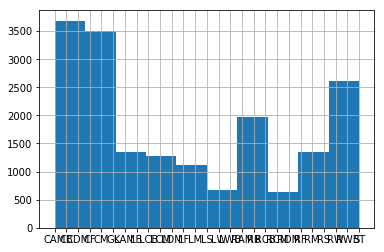

In [9]:
# Otteniamo quindi un grafico che mostra la frequenza delle varie posizioni
fifa19_clean["Position"].hist()
plt.show()

Essendo molte le posizioni possibili in campo, questo grafico risulta illegible; sistemiamone la dimensione

In [10]:
fig_size = plt.rcParams["figure.figsize"]
fig_size

[6.0, 4.0]

In [11]:
# Set figure width to 12 and height to 6
fig_size[0] = 12
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size

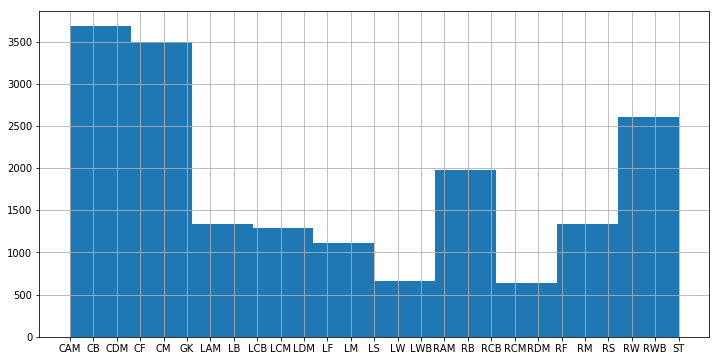

In [12]:
fifa19_clean["Position"].hist()
plt.show()

Quindi, a occhio, sono in maggioranza:
- CAM (centrocampista offensivo)
- CB (difensore centrale)
- CDM (centrocampista difensivo) 
- CF (seconda punta) 
- CM (centrocampista) 
- GK (portiere)

Seguono:
- RW (ala destra)
- RWB (ala destra difensiva)
- ST (attacante)

**NOTA:** Ragionando su quello che abbiamo in mano, classificare i portieri sarebbe fin troppo facile; rimuoviamoli dal dataframe

In [13]:
fifa19_wGK = fifa19_clean.copy()

fifa19_wGK['Position'] = fifa19_wGK['Position'].str.strip()
fifa19_wGK = fifa19_wGK[fifa19_wGK['Position'] != 'GK']

Controlliamo se ci sono giocatori per i quali non è stata inserita la posizione e quindi hanno in quel campo un valore nullo

In [14]:
print("Pos NaN total is: ", fifa19_wGK[['Position']].isnull().sum().sum())

Pos NaN total is:  60


Abbiamo riscontrato 60 giocatori senza posizione nel dataset; **eliminiamo quindi gli item con valori nulli che possono creare problemi**

In [15]:
fifa19_wGK.dropna(inplace=True)

In [16]:
print("Pos NaN total is: ", fifa19_wGK[['Position']].isnull().sum().sum())

Pos NaN total is:  0


**Ora non ci sono più giocatori senza posizione,** creiamo un array contente tutte le posizioni

In [17]:
p = fifa19_wGK['Position'].str.split().apply(lambda x: x[0]).unique()
p

array(['RF', 'ST', 'LW', 'RCM', 'LF', 'RS', 'RCB', 'LCM', 'CB', 'LDM',
       'CAM', 'CDM', 'LS', 'LCB', 'RM', 'LAM', 'LM', 'LB', 'RDM', 'RW',
       'CM', 'RB', 'RAM', 'CF', 'RWB', 'LWB'], dtype=object)

A questo punto è importante **gestire i giocatori più duttili che possono ricoprire più posizioni**: duplichiamo quindi il set di dati laddove questo si verifica

In [18]:
df_new = fifa19_wGK.copy()
df_new.drop(df_new.index, inplace=True)

for i in p:
    df_temp = fifa19_wGK[fifa19_wGK['Position'].str.contains(i)]
    df_temp['Position'] = i
    df_new = df_new.append(df_temp, ignore_index=True)
    
df_new.iloc[::500, :]

C:\Users\demia\Documents\WinPython-64bit-3.6.3.0Qt5\python-3.6.3.amd64\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Aggression,Crossing,Curve,Dribbling,Finishing,FKAccuracy,HeadingAccuracy,LongShots,Penalties,ShotPower,...,Agility,Reactions,Stamina,BallControl,Balance,Composure,Jumping,SprintSpeed,Positioning,Position
0,48,84,93,97,95,94,70,94,75,85,...,91,95,72,96,95,96,68,86,94,RF
500,71,28,38,59,73,42,79,53,60,69,...,57,69,77,58,55,61,62,76,76,ST
1000,66,52,62,62,60,62,62,59,68,68,...,74,67,66,65,72,65,72,65,72,ST
1500,64,48,63,65,62,48,71,57,64,62,...,63,60,63,60,67,65,87,63,53,ST
2000,37,31,41,45,57,31,52,51,58,47,...,70,53,51,52,81,45,69,73,59,ST
2500,41,60,46,66,67,36,63,63,62,63,...,57,66,54,64,72,58,70,60,63,LW
3000,79,41,40,50,31,35,51,42,44,61,...,55,55,68,57,47,62,62,47,41,RCM
3500,70,25,27,36,24,30,75,36,32,36,...,71,67,79,55,64,67,80,74,22,RCB
4000,71,56,44,62,52,60,58,50,58,58,...,61,71,79,64,64,72,73,62,62,LCM
4500,73,37,27,44,24,27,77,22,35,35,...,64,71,66,55,68,70,90,64,20,CB


Guardando il dataset originale **si nota che alcuni attributi hanno segni '+/-'**, eseguiamo il calcolo anziché tenerli come stringa:

In [19]:
cols = [col for col in df_new.columns if col not in ['Position']]

for i in cols:
    df_new[i] = df_new[i].apply(lambda x: eval(x) if isinstance(x,str) else x)

df_new.iloc[::500, :]

,Aggression,Crossing,Curve,Dribbling,Finishing,FKAccuracy,HeadingAccuracy,LongShots,Penalties,ShotPower,...,Agility,Reactions,Stamina,BallControl,Balance,Composure,Jumping,SprintSpeed,Positioning,Position
0,48,84,93,97,95,94,70,94,75,85,...,91,95,72,96,95,96,68,86,94,RF
500,71,28,38,59,73,42,79,53,60,69,...,57,69,77,58,55,61,62,76,76,ST
1000,66,52,62,62,60,62,62,59,68,68,...,74,67,66,65,72,65,72,65,72,ST
1500,64,48,63,65,62,48,71,57,64,62,...,63,60,63,60,67,65,87,63,53,ST
2000,37,31,41,45,57,31,52,51,58,47,...,70,53,51,52,81,45,69,73,59,ST
2500,41,60,46,66,67,36,63,63,62,63,...,57,66,54,64,72,58,70,60,63,LW
3000,79,41,40,50,31,35,51,42,44,61,...,55,55,68,57,47,62,62,47,41,RCM
3500,70,25,27,36,24,30,75,36,32,36,...,71,67,79,55,64,67,80,74,22,RCB
4000,71,56,44,62,52,60,58,50,58,58,...,61,71,79,64,64,72,73,62,62,LCM
4500,73,37,27,44,24,27,77,22,35,35,...,64,71,66,55,68,70,90,64,20,CB


## FASE 2: Normalizzazione dei dati

Come appare lo schema degli attributi per ogni posizione? 
Facciamo un esempio con la posizione di attaccante (ST), ruolo fra i più frequenti, con ricampionamento ogni 200 giocatori

Text(22,100,'Mixed Attributes')

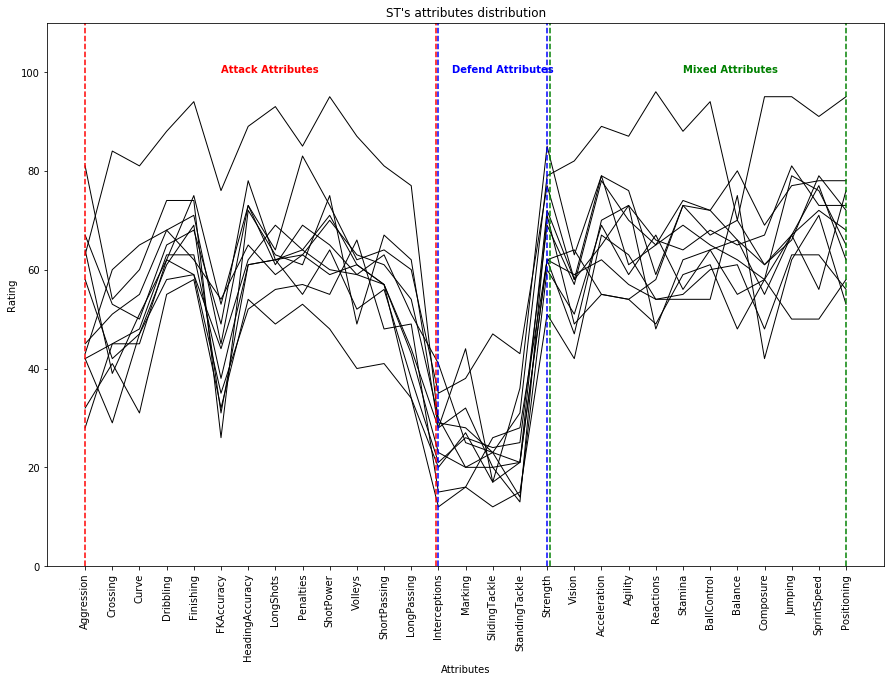

In [20]:
fig, ax = plt.subplots()
df_new_ST = df_new[df_new['Position'] == 'ST'].iloc[::200,:-1]
df_new_ST.T.plot.line(color = 'black', figsize = (15,10), legend = False, ylim = (0, 110), title = "ST's attributes distribution", ax=ax)

ax.set_xlabel('Attributes')
ax.set_ylabel('Rating')

ax.set_xticks(np.arange(len(cols)))
ax.set_xticklabels(labels = cols, rotation=90)

for ln in ax.lines:
    ln.set_linewidth(1)
    
ax.axvline(0, color='red', linestyle='--')   
ax.axvline(12.9, color='red', linestyle='--')

ax.axvline(13, color='blue', linestyle='--')
ax.axvline(17, color='blue', linestyle='--')

ax.axvline(17.1, color='green', linestyle='--')
ax.axvline(28, color='green', linestyle='--')

ax.text(5, 100, 'Attack Attributes', color = 'red', weight = 'bold')
ax.text(13.5, 100, 'Defend Attributes', color = 'blue', weight = 'bold')
ax.text(22, 100, 'Mixed Attributes', color = 'green', weight = 'bold')

Era abbastanza ovvia la propensione a caratteristiche di attacco, ma si trovano alcuni valori anomali. Questo perché alcuni giocatori sono estremamente bravi nelle loro posizioni e altri non lo sono. Credo che la maggior parte di loro debba seguire un modello simile, proviamo a normalizzarli per la stessa posizione 

**Normalizzazione:** Di fatto vengono considerati tutti i valori per ogni singolo attributo (scorrendo le righe per ogni colonna) e viene estrapolato il rapporto del singolo valore con la media dei valori di quel attributo specifico, in modo tale da averli più uniformi

Text(22,0.07,'Mixed Attributes')

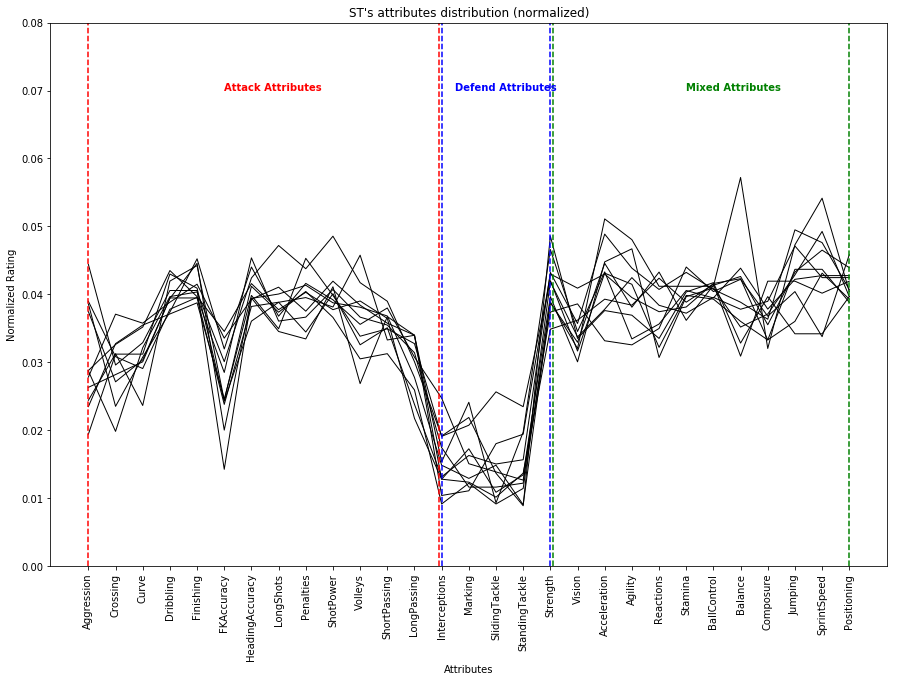

In [21]:
df_new_ST_normalized = df_new_ST.div(df_new_ST.sum(axis=1), axis=0)

fig, ax = plt.subplots()
df_new_ST_normalized.T.plot.line(color = 'black', figsize = (15,10), ylim = (0, 0.08), legend = False, title = "ST's attributes distribution (normalized)", ax=ax)

ax.set_xlabel('Attributes')
ax.set_ylabel('Normalized Rating')

ax.set_xticks(np.arange(len(cols)))
ax.set_xticklabels(labels = cols, rotation=90)

for ln in ax.lines:
    ln.set_linewidth(1)

ax.axvline(0, color='red', linestyle='--')   
ax.axvline(12.9, color='red', linestyle='--')

ax.axvline(13, color='blue', linestyle='--')
ax.axvline(17, color='blue', linestyle='--')

ax.axvline(17.1, color='green', linestyle='--')
ax.axvline(28, color='green', linestyle='--')

ax.text(5, 0.07, 'Attack Attributes', color = 'red', weight = 'bold')
ax.text(13.5, 0.07, 'Defend Attributes', color = 'blue', weight = 'bold')
ax.text(22, 0.07, 'Mixed Attributes', color = 'green', weight = 'bold')

**Ora c'è molto meno rumore,** la teoria era corretta

## FASE 3: Predire target binari (attacco VS difesa)
Lo schema dopo la normalizzazione sembra migliorato. Ora vediamo di:
- Normalizzare l'intero dataframe
- Riclassificare il valore del target (position) in gruppi binari come segue:
    - 1 = posizione di attacco = ST, RW, LAM, LW, RAM, RM, CM, LM, CAM, CF, RF, RCM, LCM, LF, LS, RS   
    - 0 = posizione di difesa = LCB, LDM, RDM, CDM, CB, LB, RB, RCB,RWB, LWB

In [22]:
df_new_normalized = df_new.iloc[:,:-1].div(df_new.iloc[:,:-1].sum(axis=1), axis=0)

mapping = {'ST': 1, 'RW': 1, 'LAM': 1, 'LW': 1, 'RAM': 1, 'RM': 1, 'CM': 1, 'LM': 1, 'CAM': 1, 
           'CF': 1, 'RF': 1, 'RCM': 1, 'LCM': 1, 'LF': 1, 'LS': 1,  'RS': 1, 'LCB': 0, 'LDM': 0, 
           'RDM': 0, 'CDM': 0, 'CB': 0, 'LB': 0, 'RB': 0, 'RCB': 0,'RWB': 0, 'LWB': 0}

df_new_normalized['Position'] = df_new['Position']
df_new_normalized = df_new_normalized.replace({'Position': mapping})

df_new_normalized.iloc[::1000,]

,Aggression,Crossing,Curve,Dribbling,Finishing,FKAccuracy,HeadingAccuracy,LongShots,Penalties,ShotPower,...,Agility,Reactions,Stamina,BallControl,Balance,Composure,Jumping,SprintSpeed,Positioning,Position
0,0.021390,0.037433,0.041444,0.043226,0.042335,0.041889,0.031194,0.041889,0.033422,0.037879,...,0.040553,0.042335,0.032086,0.042781,0.042335,0.042781,0.030303,0.038324,0.041889,1
1000,0.038551,0.030374,0.036215,0.036215,0.035047,0.036215,0.036215,0.034463,0.039720,0.039720,...,0.043224,0.039136,0.038551,0.037967,0.042056,0.037967,0.042056,0.037967,0.042056,1
2000,0.026890,0.022529,0.029797,0.032703,0.041424,0.022529,0.037791,0.037064,0.042151,0.034157,...,0.050872,0.038517,0.037064,0.037791,0.058866,0.032703,0.050145,0.053052,0.042878,1
3000,0.052249,0.027116,0.026455,0.033069,0.020503,0.023148,0.033730,0.027778,0.029101,0.040344,...,0.036376,0.036376,0.044974,0.037698,0.031085,0.041005,0.041005,0.031085,0.027116,1
4000,0.038234,0.030156,0.023694,0.033387,0.028002,0.032310,0.031233,0.026925,0.031233,0.031233,...,0.032849,0.038234,0.042542,0.034464,0.034464,0.038772,0.039311,0.033387,0.033387,1
5000,0.043231,0.034699,0.019909,0.025028,0.030148,0.017065,0.039818,0.023322,0.026735,0.033561,...,0.038680,0.039249,0.039249,0.038111,0.034130,0.039818,0.040956,0.031286,0.034130,0
6000,0.037468,0.036176,0.019380,0.029070,0.021318,0.020026,0.042636,0.023256,0.021964,0.022610,...,0.045866,0.038760,0.051680,0.034884,0.034238,0.033592,0.037468,0.040052,0.031008,0
7000,0.040878,0.017411,0.018168,0.033308,0.012112,0.021953,0.052233,0.016654,0.026495,0.028009,...,0.039364,0.042392,0.040878,0.034822,0.041635,0.043906,0.055261,0.035579,0.015140,0
8000,0.028152,0.036720,0.034884,0.041616,0.034884,0.027540,0.031212,0.034884,0.033048,0.037944,...,0.044064,0.042840,0.044064,0.044064,0.044064,0.034884,0.025092,0.042228,0.042840,1
9000,0.037264,0.032258,0.032258,0.035039,0.030590,0.018354,0.035595,0.033370,0.034483,0.036151,...,0.036707,0.035595,0.035595,0.038376,0.037820,0.037264,0.035039,0.030033,0.034483,0


Controlliamo quanti sono i giocatori in attacco e quanti quelli in difesa

In [23]:
diz={'Attacco': 0, 'Difesa': 0}

for i in df_new_normalized['Position']:
    if i == 0:
        diz['Difesa']+=1
    elif i == 1:
        diz['Attacco']+=1

diz

{'Attacco': 9768, 'Difesa': 8615}

**La differenza non è così grande da obbligarci a pareggiare i numeri, per questo step teniamoli così**

Come dicono l'internet e i mille progetti visti in giro, quando si tratta di lavorare con valori binari la Logistic Regression e il Decision Tree sono la scelta migliore, mettiamoli alla prova . .

### Applichiamo la Logistic Regression, dopo aver opportunamente diviso in set di train e test:

In [24]:
X_train, X_test, y_train, y_test = train_test_split(df_new_normalized.iloc[:,:-1], df_new_normalized.iloc[:,-1], random_state=0)

print('X train shape: {}'.format(X_train.shape))
print('X test shape: {}'.format(X_test.shape))
print('y train shape: {}'.format(y_train.shape))
print('y test shape: {}'.format(y_test.shape))

X train shape: (13787, 29)
X test shape: (4596, 29)
y train shape: (13787,)
y test shape: (4596,)


In [25]:
clf_d = DummyClassifier(strategy='uniform', random_state=1).fit(X_train, y_train)
acc_d = clf_d.score(X_test, y_test)
print ('Dummy Classifier (baseline): {}'.format(acc_d))

clf = LogisticRegression().fit(X_train, y_train)
acc = clf.score(X_test, y_test)
print ('Logistic Regression Accuracy: {}'.format(acc))

Dummy Classifier (baseline): 0.5030461270670148
Logistic Regression Accuracy: 0.8853350739773717


Abbiamo quindi la “baseline” data da Dummy Classifier (https://chrisalbon.com/machine_learning/model_evaluation/create_baseline_classification_model/) e l'accuratezza della Logistic Regression che risulta essere alta, ma non come ci si poteva aspettare dato il compito è binario

**Vediamo quali sono gli attibuti che influiscono maggiormente . .**

In [26]:
Coef_list = list(sorted(zip(X_train.columns, abs(clf.coef_[0])),key=lambda x: -x[1]))
Coef_table = pd.DataFrame(np.array(Coef_list).reshape(-1,2), columns = ['Attributes', 'Coef'])

print (Coef_table)

         Attributes            Coef
0     SlidingTackle   19.1988728547
1    StandingTackle   18.5365004072
2     Interceptions   17.2604638404
3           Marking    16.702364893
4         Finishing    14.651514561
5       Positioning   10.6000608969
6         LongShots   10.3255172858
7           Volleys   10.2003447809
8            Vision   8.53425338277
9        Aggression   8.42208939857
10         Strength   7.55202871226
11  HeadingAccuracy    7.1305457913
12        Penalties   6.79401902015
13        Dribbling   6.64873947951
14        ShotPower   6.22201464008
15            Curve   5.76054264127
16       FKAccuracy   5.60694455492
17          Jumping   5.54573381245
18          Agility   4.91977693897
19          Balance   4.19021729974
20      BallControl   3.61098661612
21          Stamina   2.74733700676
22     Acceleration    2.5850738063
23        Reactions   1.73549631257
24      SprintSpeed   1.66508833861
25     ShortPassing   1.58310184224
26      LongPassing  0.77065

**. . e proviamo a considerare solamente i primi 10 attributi di questa classifica, quindi quelli che hanno maggiore potere predittivo:**

In [27]:
target_cols = Coef_table[:10]['Attributes'].tolist()

clf_2 = LogisticRegression().fit(X_train[target_cols], y_train)
acc_2 = clf_2.score(X_test[target_cols], y_test)
print ('Logistic Regression Accuracy (10 features): {}'.format(acc_2))

Logistic Regression Accuracy (10 features): 0.8929503916449086


La situazione è analoga, forse non basta questa mossa

### Piccola parentesi: matrice di confusione (veri/falsi positivi/negativi)

In [28]:
LogReg = LogisticRegression().fit(X_train[target_cols], y_train)
y_ris = LogReg.predict(X_test[target_cols])
print(metrics.confusion_matrix(y_test, y_ris))

[[1942  183]
 [ 309 2162]]


**1942** si riferisce al numero di veri negativi e **2162** al numero di veri positivi
**309** si riferisce invece al numero di falsi negativi e **183** ai falsi positivi

- I VERI POSITIVI e i VERI NEGATIVI riguardano tutti i casi in cui il classificatore predice in modo corretto se il giocatore del dataset è in difesa o attacco
- I FALSI POSITIVI e i FALSI NEGATIVI riguardano invece quei casi in cui il classificatore prevede una posizione sbagliata rispetto a quella reale

### Proviamo a vedere se la matrice di confusione (Pearson Correlation of attributes), che mostra quali parametri vengono confusi con quali, ci aiuta a capire dove andare a parare

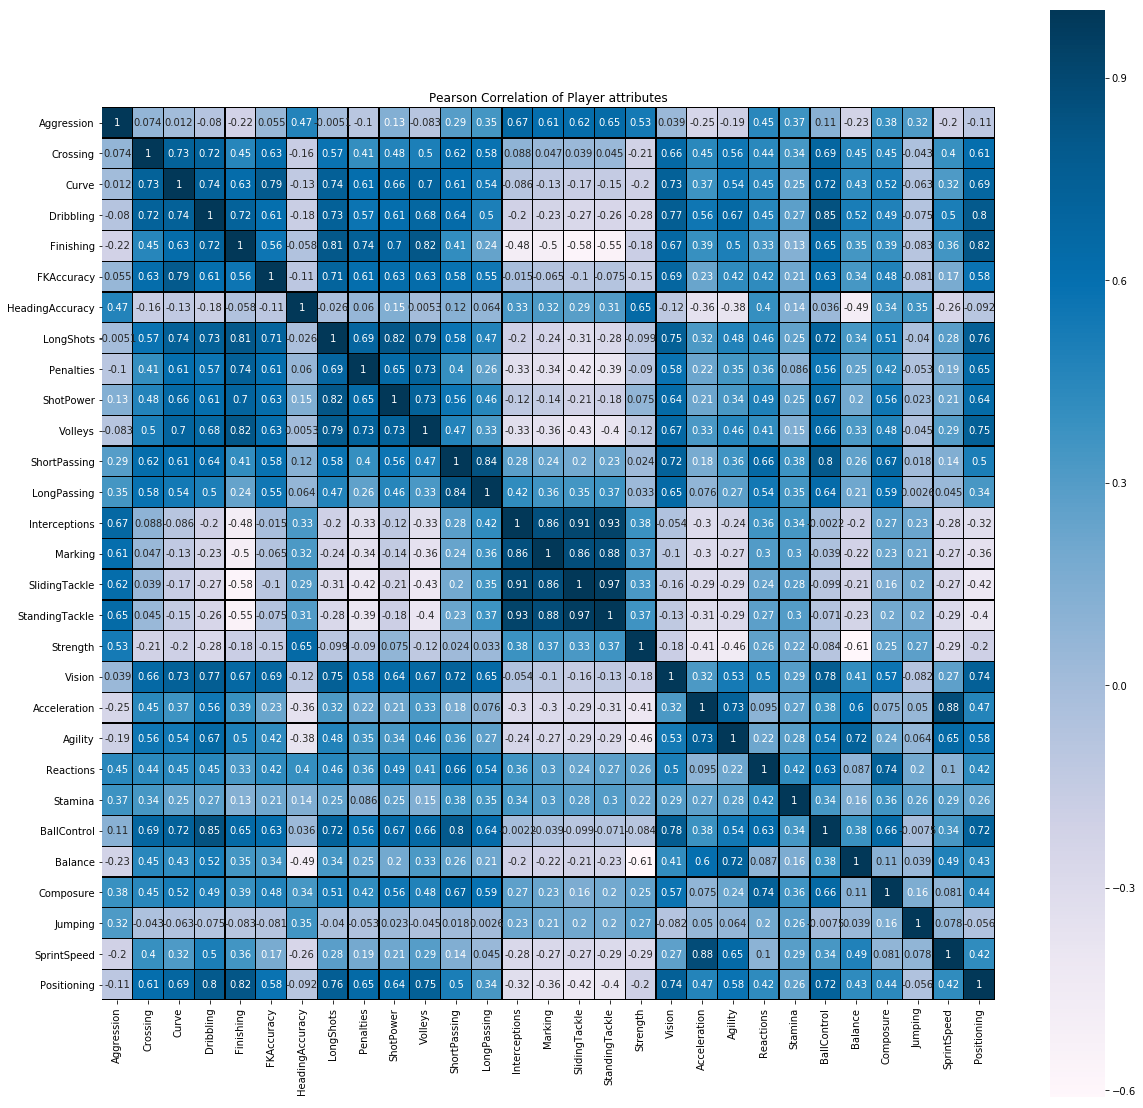

In [29]:
f, ax = plt.subplots(figsize=(20, 20))

plt.title('Pearson Correlation of Player attributes')

sns.heatmap(df_new.corr(),linewidths=0.25,vmax=1.0, square=True, cmap = 'PuBu', linecolor='black', annot=True)

Interception, Marking, Sliding Tackle e Standing Tackle sono le categorie dove si verifica maggiore confusione, ma non sono sole. A prescindere da tutto la mole di dati presenti non ci aiuta a estrapolare informazioni particolarmente utili: forse questa matrice (Pearson Correlation) non è lo strumento migliore per comprendere la situazione, **continuiamo con l'altro algoritmo e poi vediamo il da farsi**

### Applichiamo Decision Tree ai due set:

In [30]:
clf_d = DummyClassifier(strategy='uniform', random_state=1).fit(X_train, y_train)
acc_d = clf_d.score(X_test, y_test)
print ('Dummy Classifier (baseline): {}'.format(acc_d))

clf = DecisionTreeClassifier().fit(X_train, y_train)
acc = clf.score(X_test, y_test)
print ('Decision Tree Accuracy: {}'.format(acc))

Dummy Classifier (baseline): 0.5030461270670148
Decision Tree Accuracy: 0.8875108790252393


**La situazione non migliora**

Proviamo con altri algoritmi mettendoli a confronto con Decision Tree

In [31]:
confronto_algoritmi(BernoulliNB, MultinomialNB, GaussianNB, DecisionTreeClassifier, df_new_normalized, 100)

[('BernoulliNB', 0.53764142732811138),
 ('MultinomialNB', 0.53764142732811138),
 ('GaussianNB', 0.88664055700609234),
 ('DecisionTreeClassifier', 0.88914055700609207)]

**La sorpresa è che Gaussian Naive Bayes (https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html) restituisce un risultato pari a Decision Tree, come mai?**

Informiamoci su come funziona questo algoritmo (anche se, conoscendo la distribuzione Gaussiana, una mezza idea ce la si può già fare): 
- https://en.wikipedia.org/wiki/Gaussian_function 

**DEFINIZIONE:** "La distribuzione gaussiana è spesso usata come prima approssimazione per descrivere quei fenomeni che sono il risultato di un gran numero di variabili indipendenti; esse tendono a concentrarsi attorno a un singolo valor medio. Il grafico della funzione di densità di probabilità associata è simmetrico e ha una forma a campana, nota come campana di Gauss"

**CONSIDERAZIONE:** Effettivamente, come si accennava prima durante la normalizzazione dei dati, ci sono giocatori che sono i migliori nei loro ruoli e altri che sono sostanzialemente scarsi. Questa situazione comporta una dipendenza non molto elevata fra le variabili in gioco. Questo non le rende indipendenti (altrimenti restituirebbe valori superiori!), ma contribuisce a permettergli di dare risultati di tutto rispetto 

# FASE 4: Predire tutte le posizioni

Terminate le prove con compiti binari andiamo un gradino sopra, anzi 26! Sì, abbiamo ben ventisei ruoli possibili, improbabile un'alta capacità predittiva, ma lasciamo parlare i dati

In [32]:
df_new_normalized_all = df_new.copy()

mapping_all = {'ST': 1, 'RW': 2, 'LAM': 3, 'LW': 4, 'RAM': 5, 'RM': 6, 'CM': 7, 'LM': 8, 'CAM': 9, 'CF': 10, 
               'RF': 11, 'RCM': 12, 'LCM': 13, 'LF': 14, 'LS': 15,  'RS': 16, 'LCB': 17, 'LDM': 18, 
               'RDM': 19, 'CDM': 20, 'CB': 21, 'LB': 22, 'RB': 23, 'RCB': 24,'RWB': 25, 'LWB': 26}

df_new_normalized_all = df_new_normalized_all.replace({'Position': mapping_all})
df_new_normalized_all.iloc[::1000,]

,Aggression,Crossing,Curve,Dribbling,Finishing,FKAccuracy,HeadingAccuracy,LongShots,Penalties,ShotPower,...,Agility,Reactions,Stamina,BallControl,Balance,Composure,Jumping,SprintSpeed,Positioning,Position
0,48,84,93,97,95,94,70,94,75,85,...,91,95,72,96,95,96,68,86,94,11
1000,66,52,62,62,60,62,62,59,68,68,...,74,67,66,65,72,65,72,65,72,1
2000,37,31,41,45,57,31,52,51,58,47,...,70,53,51,52,81,45,69,73,59,1
3000,79,41,40,50,31,35,51,42,44,61,...,55,55,68,57,47,62,62,47,41,12
4000,71,56,44,62,52,60,58,50,58,58,...,61,71,79,64,64,72,73,62,62,13
5000,76,61,35,44,53,30,70,41,47,59,...,68,69,69,67,60,70,72,55,60,21
6000,58,56,30,45,33,31,66,36,34,35,...,71,60,80,54,53,52,58,62,48,21
7000,54,23,24,44,16,29,69,22,35,37,...,52,56,54,46,55,58,73,47,20,21
8000,46,60,57,68,57,45,51,57,54,62,...,72,70,72,72,72,57,41,69,70,9
9000,67,58,58,63,55,33,64,60,62,65,...,66,64,64,69,68,67,63,54,62,20


In [33]:
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(df_new_normalized_all.iloc[:,:-1], df_new_normalized_all.iloc[:,-1], random_state=0)

print('X train shape: {}'.format(X_train_all.shape))
print('X test shape: {}'.format(X_test_all.shape))
print('y train shape: {}'.format(y_train_all.shape))
print('y test shape: {}'.format(y_test_all.shape))

X train shape: (13787, 29)
X test shape: (4596, 29)
y train shape: (13787,)
y test shape: (4596,)


In [34]:
clf_d_all = DummyClassifier(strategy='uniform', random_state=1).fit(X_train_all, y_train_all)
acc_d_all = clf_d_all.score(X_test_all, y_test_all)
print ('Dummy Classifier (baseline): {}'.format(acc_d_all))

clf_all = LogisticRegression().fit(X_train_all, y_train_all)
acc_all = clf_all.score(X_test_all, y_test_all)
print ('Logistic Regression Accuracy: {}'.format(acc_all))

Dummy Classifier (baseline): 0.03894691035683203
Logistic Regression Accuracy: 0.4965187119234117


**Vista la baseline l'accuratezza della Logistic Regression non è poi così male!** Che tipo di accortezze possiamo avere per migliorare la situazione?

### Proviamo a trovare i 10 ruoli più frequenti e lavorare su questo

**NB:** 10 perchè in campo sono 10 + 1 (portiere che abbiamo già escluso 😢); per ora lavoriamo per frequenza, vedremo poi se con questi ci si può fare una formazione o meno e quindi se sono equilibrati per ruoli e caratteristiche 

In [35]:
fr = FreqDist(df_new_normalized_all['Position']).most_common(10)
fr

[(21, 3088),
 (7, 2180),
 (1, 2152),
 (22, 1322),
 (23, 1291),
 (6, 1124),
 (8, 1095),
 (9, 958),
 (20, 948),
 (24, 662)]

**Vediamo** (per curiosità) **a quali posizioni corrispondono**

In [36]:
select = [i[0] for i in fr]

for i in select:
    for key, value in mapping_all.items() :
        if i == value:
            print(key)

CB
CM
ST
LB
RB
RM
LM
CAM
CDM
RCB


I ruoli più frequenti sono quindi:

- 25 = CB = Difensore centrale
- 7 = CM= Centrocampista
- 1 = ST = Attacante
- 26 = LB = Terzino sinistro
- 27 = RB= Terzino destro
- 6 = RM= Esterno destro
- 8 = LM = Esterno sinistro
- 9 = CAM= Centrocampista offensivo
- 24 = CDM = Centrocampista difensivo
- 28 = RCB = Mezz'ala destra

Ora creiamo un dataframe contenente gli item che ricoprono solo queste 10 posizioni

In [37]:
df_norm_all_select = df_new_normalized_all.copy()

In [38]:
df_norm_all_select = df_norm_all_select.loc[df_norm_all_select['Position'].isin(select)]

In [39]:
print("Items processati prima: ",len(df_new_normalized_all['Position']), \
      "\nItems processati dopo:",len(df_norm_all_select['Position']))

Items processati prima:  18383 
Items processati dopo: 14820


Sono circa 3500 i giocatori degli altri ruoli, **procediamo con Logistic Regression**

In [40]:
X_train_all_select, X_test_all_select, y_train_all_select, y_test_all_select = train_test_split(df_norm_all_select.iloc[:,:-1], df_norm_all_select.iloc[:,-1], random_state=0)

print('X train shape: {}'.format(X_train_all_select.shape))
print('X test shape: {}'.format(X_test_all_select.shape))
print('y train shape: {}'.format(y_train_all_select.shape))
print('y test shape: {}'.format(y_test_all_select.shape))

X train shape: (11115, 29)
X test shape: (3705, 29)
y train shape: (11115,)
y test shape: (3705,)


In [41]:
clf_d_all_select = DummyClassifier(strategy='uniform', random_state=1).fit(X_train_all_select, y_train_all_select)
acc_d_all_select = clf_d_all_select.score(X_test_all_select, y_test_all_select)
print ('Dummy Classifier (baseline): {}'.format(acc_d_all_select))

clf_all_select = LogisticRegression().fit(X_train_all_select, y_train_all_select)
acc_all_select = clf_all_select.score(X_test_all_select, y_test_all_select)
print ('Logistic Regression Accuracy: {}'.format(acc_all_select))

Dummy Classifier (baseline): 0.10229419703103913
Logistic Regression Accuracy: 0.6037786774628879


**La situazione migliora! Non male il 60% vista la situazione** 

### Applichiamo Decision Tree ai due set:

In [42]:
clf_d_all_select = DummyClassifier(strategy='uniform', random_state=1).fit(X_train_all_select, y_train_all_select)
acc_d_all_select = clf_d_all_select.score(X_test_all_select, y_test_all_select)
print ('Dummy Classifier (baseline): {}'.format(acc_d_all_select))

clf_all_select = DecisionTreeClassifier().fit(X_train_all_select, y_train_all_select)
acc_all_select = clf_all_select.score(X_test_all_select, y_test_all_select)
print ('Decision Tree Accuracy: {}'.format(acc_all_select))

Dummy Classifier (baseline): 0.10229419703103913
Decision Tree Accuracy: 0.48663967611336034


**In questo caso l'accuratezza peggiora di molto;** qui Logistic Regression batte Decision Tree significativamente, proviamo a confrontarla con altri algoritmi

In [43]:
confronto_algoritmi(BernoulliNB, MultinomialNB, GaussianNB, LogisticRegression, df_norm_all_select, 100)

[('BernoulliNB', 0.20512820512820512),
 ('MultinomialNB', 0.5395411605937922),
 ('GaussianNB', 0.51147098515519585),
 ('LogisticRegression', 0.60377867746288794)]

**Niente da fare, Logistic Regression resta in testa!**

Dobbiamo considerare che abbiamo preso 10 ruoli a caso senza nemmeno guardare come sono distribuiti in campo (e quindi se è maggiore in un numero la presenza di caratteristiche difensive o di attacco) e quanti sono per ogni ruolo i giocatori presi in considerazione, potremmo avere Bias non da poco in questa condizione, verifichiamo

# Proviamo a predire tutte le posizioni, ma cambiando approccio
**Equilibriamo i dati**: facciamo sì che tutte le posizioni abbiano egual numero di giocatori, se questa non fosse la migliore scelta perché si ridurebbero di troppo i dati che si trattano, selezioneremo posizioni prototipiche per ogni settore

In [59]:
fr_all = FreqDist(df_new_normalized_all['Position'])
fr_all.most_common()

[(21, 3088),
 (7, 2180),
 (1, 2152),
 (22, 1322),
 (23, 1291),
 (6, 1124),
 (8, 1095),
 (9, 958),
 (20, 948),
 (24, 662),
 (17, 648),
 (4, 459),
 (2, 457),
 (13, 395),
 (12, 391),
 (19, 248),
 (18, 243),
 (15, 207),
 (16, 203),
 (25, 87),
 (26, 78),
 (10, 74),
 (3, 21),
 (5, 21),
 (11, 16),
 (14, 15)]

Come immaginavo, se si normalizzasse basandosi sul ruolo con frequenza minore si avrebbe una rappresentanza di 15 giocatori per ruolo e quindi il dataframe scenderebbe a 260 item (15 giocatori x 26 classi); **indaghiamo i ruoli che ricoprono prima di procedere**

In [60]:
pos_val = [i[0] for i in fr_all.most_common()]
pos_freq = [i[1] for i in fr_all.most_common()]

pos_name=[]

for i in pos_val:
    for key, value in mapping_all.items():
        if i == value:
            pos_name.append(key)

correlation = dict(zip(pos_name, pos_freq))
sort_corr = sorted(correlation.items(), key=operator.itemgetter(1), reverse=True)
sort_corr

[('CB', 3088),
 ('CM', 2180),
 ('ST', 2152),
 ('LB', 1322),
 ('RB', 1291),
 ('RM', 1124),
 ('LM', 1095),
 ('CAM', 958),
 ('CDM', 948),
 ('RCB', 662),
 ('LCB', 648),
 ('LW', 459),
 ('RW', 457),
 ('LCM', 395),
 ('RCM', 391),
 ('RDM', 248),
 ('LDM', 243),
 ('LS', 207),
 ('RS', 203),
 ('RWB', 87),
 ('LWB', 78),
 ('CF', 74),
 ('LAM', 21),
 ('RAM', 21),
 ('RF', 16),
 ('LF', 15)]

**I primi 9 ordinati per frequenza sono:**

- CB = Difensore centrale
- CM= Centrocampista
- ST = Attacante
- LB = Terzino sinistro
- RB= Terzino destro
- RM= Esterno destro
- LM = Esterno sinistro
- CAM= Centrocampista offensivo
- CDM = Centrocampista difensivo

Per nostra fortuna, se consideriamo questi, **abbiamo i ruoli più rappresentativi:** infatti, disegnandoli sul rettangolo di gioco risultano ricoprire tutte le zone principali!

**NOTA:** Il decimo rovinava la simmetria, anche l'occhio fa la sua parte 😉 a parte gli scherzi, con 10 paradossalmente sarebbero stati sbilanciati i ruoli in attacco e difesa: con nove abbiamo 4 avanti, 4 dietro e uno che avrà caratteristiche dell'uno e dell'altro

#### Ora occupiamoci di creare un dataframe contente solo le posizioni desiderate

In [53]:
df_select = df_new_normalized_all.copy()

In [54]:
df_select = df_select.loc[df_select['Position'].isin(pos_val[:9])]

In [55]:
print("Items processati prima: ",len(df_new_normalized_all['Position']), \
      "\nItems processati dopo:",len(df_select['Position']))

Items processati prima:  18383 
Items processati dopo: 14158


### Bene, ora distribuiamo il tutto, dobbiamo avere 948 item di ogni posizione

**NB:** 948 è la frequenza minore fra le 9 posizioni scelte

In [67]:
df_select_eq = df_select.groupby('Position').head(948)
print("Controlliamo la forma del dataframe:", df_select_eq.shape)

Controlliamo la forma del dataframe: (8532, 30)


Controlliamo siano divisi equamente per ruolo:

In [68]:
FreqDist(df_select_eq['Position'])

FreqDist({1: 948,
          6: 948,
          7: 948,
          8: 948,
          9: 948,
          20: 948,
          21: 948,
          22: 948,
          23: 948})

**Tutto apposto, procediamo**

In [69]:
X_train_select_eq, X_test_select_eq, y_train_select_eq, y_test_select_eq = train_test_split(df_select_eq.iloc[:,:-1], df_select_eq.iloc[:,-1], random_state=0)

print('X train shape: {}'.format(X_train_select_eq.shape))
print('X test shape: {}'.format(X_test_select_eq.shape))
print('y train shape: {}'.format(y_train_select_eq.shape))
print('y test shape: {}'.format(y_test_select_eq.shape))

X train shape: (6399, 29)
X test shape: (2133, 29)
y train shape: (6399,)
y test shape: (2133,)


In [70]:
clf_d_select_eq = DummyClassifier(strategy='uniform', random_state=1).fit(X_train_select_eq, y_train_select_eq)
acc_d_select_eq = clf_d_select_eq.score(X_test_select_eq, y_test_select_eq)
print ('Dummy Classifier (baseline): {}'.format(acc_d_select_eq))

clf_select_eq = LogisticRegression().fit(X_train_select_eq, y_train_select_eq)
acc_select_eq = clf_select_eq.score(X_test_select_eq, y_test_select_eq)
print ('Logistic Regression Accuracy: {}'.format(acc_select_eq))

Dummy Classifier (baseline): 0.10689170182841069
Logistic Regression Accuracy: 0.5850914205344585


**Stranamente la situazione non è peggiorata quasi di nulla!** 

Vediamo un attimo gli altri algoritmi:

In [71]:
confronto_algoritmi(BernoulliNB, MultinomialNB, GaussianNB, DecisionTreeClassifier, df_select_eq, 100)

[('BernoulliNB', 0.10595405532114391),
 ('MultinomialNB', 0.5199249882794188),
 ('GaussianNB', 0.57290201593999046),
 ('DecisionTreeClassifier', 0.4813267698077825)]

**P.S.** Anche in questo caso Gaussian Naive Bayes ha una prestazione non indifferente

## Non è da tralasciare il quasi 60% della Logistic Regression, è possibile migliorare ulteriormente la situazione? 

La documentazione (https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) ci mostra che la Logistic Regression ha molti parametri che possiamo sfruttare, proviamo a studiarle . .

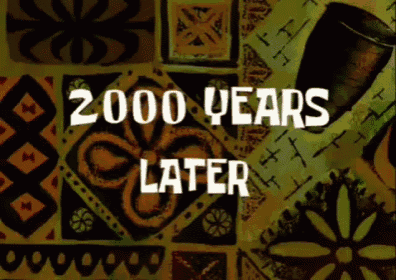

Dopo aver studiato più a fondo questo algoritmo vediamo se le due possibili soluzioni possono apportare miglioramenti sull'accutarezza del nostro algoritmo: 

In [72]:
'''
solver : str, {‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’}
Algorithm to use in the optimization problem.
    - For multiclass problems, only ‘newton-cg’, ‘sag’, ‘saga’ and ‘lbfgs’ 
      handle multinomial loss

multi_class : str, {‘ovr’, ‘multinomial’, ‘auto’}
If the option chosen is ‘ovr’, then a binary problem is fit for each label. 
    - For ‘multinomial’ the loss minimised is the multinomial loss fit across 
      the entire probability distribution
'''

clf_param = LogisticRegression(solver='lbfgs', multi_class='multinomial').fit(X_train_select_eq, y_train_select_eq)
acc_param = clf_param.score(X_test_select_eq, y_test_select_eq)
print ('Logistic Regression Accuracy: {}'.format(acc_param))

Logistic Regression Accuracy: 0.5911861228316925


Abbiamo recuperato un solo punto percentuale aggiungendo questi due parametri che sembravano fare al caso nostro, proviamo altro

In [73]:
'''
penalty : str, ‘l1’, ‘l2’, ‘elasticnet’ or ‘none’
Used to specify the norm used in the penalization. 
    - The ‘newton-cg’, ‘sag’ and ‘lbfgs’ solvers support only l2 penalties. 
      ‘elasticnet’ is only supported by the ‘saga’ solver

C : float
Inverse of regularization strength; must be a positive float. 
    - Like in support vector machines, smaller values specify stronger 
      regularization
      
random_state : int, RandomState instance or None
The seed of the pseudo random number generator to use when shuffling the data. 
    - If int, random_state is the seed used by the random number generator; 
'''

clf_param = LogisticRegression(penalty='l2', C=i, random_state=0).fit(X_train_select_eq, y_train_select_eq)
acc_param = clf_param.score(X_test_select_eq, y_test_select_eq)
print ('Logistic Regression Accuracy: {}'.format(acc_param))

Logistic Regression Accuracy: 0.5939990623534928


Anche in questo caso nulla di più

________________________________________________________________________________________________________________________________

# Riassunto delle fasi, raccolta esiti e conclusioni

Dopo la fase iniziale di esplorazione e normalizzazione, abbiamo iniziato ad affrontare un semplice compito di previsione binaria:
- in questo caso Logistic Regression, Decision Tree e Gaussian Naive Bayes hanno ottenuto tutti una previsione dell'88% 
- il tentativo di lavorare solo con i 10 attributi con maggiore potere predittivo, ha portato Logistic Regression a salire di un punto percentuale nella sua accuratezza

L'attenzione si è spostata sulla predizione delle singole posizioni:
- con Logistic Regression siamo partiti con un modesto 49%, di fronte a 26 target possibili
- ci siamo poi alzati al 60% dopo aver preso in considerazione i 10 ruoli più frequenti, eliminando di fatto 3500 items e i corrispettivi 16 target (gli altri classificatori in questo caso non sono comparabili in fatto di prestazioni offerte)

Sono stati quindi identificati i ruoli più significativi (9) ed è stato normalizzato il dataframe ricavando lo stesso numero di items per ruolo:
- Logistic Regression è scesa di soli due punti percentuale, risultato niente male (anche qui gli altri classificatori non offrono risultati soddisfacenti o degni di nota)

A questo punto il tentativo di "giocare" con i parametri dell'algoritmo più efficiente (Logistic Regression) non ha portato molti frutti, se non riavvicinarsi ad un risultato del 60% che, vista la situazione, può essere considerato discreto-buono

**CONSIDERAZIONE FINALE** Un aspetto che è stato messo in luce alcune volte è la bravura dei giocatori nei loro ruoli: abbiamo a che fare con i migliori nel loro ruolo (che avranno statistiche degli attributi inerenti molto alte) e con i più scarsi nel loro ruolo (che avranno statistiche degli attributi inerenti molto basse). Questo aspetto mette in seria difficoltà un classificatore che quando si tratta dei migliori "non può sbagliare", ma quando si tratta degli scarsi "non sa se attribuirlo a quella categoria". Tralasciando i termini, ho pensato ad una possibile soluzione a questo problema. Si potrebbe dividere il dataset partendo dagli 'Overall' (il punteggio totale attribuito al giocatore *per quel ruolo*): quindi creare delle "fasce di valore"  che saranno il target da riconoscere (ad esempio, attaccanti scarsi e attacanti forti, oppure suddividere di più in attaccanti forti, attacanti medi e attacanti scarsi). A questo punto, avendo sottocategorie per ruolo, se gli items delle categorie terminanti "scarsi" saranno sufficienti in numero, potrebbe essere che il classificatore impari di più a riconoscere suddette categorie.